In [76]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore", message="X has feature names, but DecisionTreeClassifier was fitted without feature names")
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score,  confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns
from statistics import mode
from datetime import datetime
# 載入資料
rf_data = pd.read_csv(r'C:\股票\股票資料\data\rf_data.csv', encoding='CP950', low_memory=False, index_col=False)
rf_data.replace([np.inf, -np.inf], 0, inplace=True)
rf_data.fillna(0, inplace=True)
rf_data['除息日'] = pd.to_datetime(rf_data['除息日'])
print(len(rf_data))
x = rf_data[['RSI10', 'RSI14', 'MOM5', 'MOM10', 'new_h_5', 'new_h_10', 'new_h_20', 'new_h_60',
             'new_l_5', 'new_l_10', 'new_l_20', 'new_l_60', 'above_MA5', 'above_MA10', 'above_MA20', 'above_MA60',
             'MA5>10', 'MA10>20', 'MA20>60', 'Bias5_P', 'Bias10_P', 'Bias20_P', 'Bias60_P',
             'Bias5_V', 'Bias10_V', 'Bias20_V', 'Bias60_V', 'ROC_II_20', 'PE_level', 'ROE', 'DPR','dividend_yield']]

y = np.ravel(rf_data[['240日內填息']])

backtest_df = pd.DataFrame()
validation_df = pd.DataFrame()
def RF(x, y):
    x_train_val, x_test, y_train_val, y_test, idx_train_val, test_idx = train_test_split(x, y, range(len(y)), test_size=0.2, stratify=y, random_state=42)
    x_train, x_val, y_train, y_val, train_idx, val_idx = train_test_split(x_train_val, y_train_val, idx_train_val, test_size=0.25, stratify=y_train_val, random_state=42)
    # x_train = x_train.drop('除息日', axis=1)
    # year_index = x_val[(x_val['除息日'].dt.year ==2016)].index
    # x_val = x.iloc[year_index]
    # y_val = y[year_index]
    # x_val = x_val.drop('除息日', axis=1)
    backtest_df['代號'] = rf_data['代號'].iloc[test_idx]
    backtest_df['除息日'] = rf_data['除息日'].iloc[test_idx]
    backtest_df['息值(元)'] = rf_data['息值(元)'].iloc[test_idx]
    backtest_df['240日不設限填息率'] = rf_data['240日不設限填息率'].iloc[test_idx]
    backtest_df['240日填息率'] = rf_data['240日填息率'].iloc[test_idx]
    backtest_df['dividend_yield'] = rf_data['dividend_yield'].iloc[test_idx]
    backtest_df['前一日收盤價'] = rf_data['前一日收盤價'].iloc[test_idx]
    backtest_df['240日後收盤價'] = rf_data['240日後收盤價'].iloc[test_idx]

    validation_df['代號'] = rf_data['代號'].iloc[val_idx]
    validation_df['除息日'] = rf_data['除息日'].iloc[val_idx]
    validation_df['息值(元)'] = rf_data['息值(元)'].iloc[val_idx]
    validation_df['240日不設限填息率'] = rf_data['240日不設限填息率'].iloc[val_idx]
    validation_df['240日填息率'] = rf_data['240日填息率'].iloc[val_idx]
    validation_df['dividend_yield'] = rf_data['dividend_yield'].iloc[val_idx]
    validation_df['industry'] = rf_data['industry'].iloc[val_idx]
    validation_df['前一日收盤價'] = rf_data['前一日收盤價'].iloc[val_idx]
    validation_df['240日後收盤價'] = rf_data['240日後收盤價'].iloc[val_idx]
# 定義隨機森林分類器
#     rf = RandomForestClassifier(n_estimators=869, max_depth=14, criterion='entropy',min_samples_split=4, min_samples_leaf=1,max_features='sqrt',random_state=42)  #二十日
#     rf = RandomForestClassifier(n_estimators=706, max_depth=8, criterion='gini',min_samples_split=2, min_samples_leaf=1,max_features='log2',random_state=42)  #六十日
    # rf = RandomForestClassifier(n_estimators=867, max_depth=6, criterion='log_loss',min_samples_split=5, min_samples_leaf=1,max_features='log2',random_state=42)  #一百二十日
    rf = RandomForestClassifier(n_estimators=677, max_depth=13, criterion='gini',min_samples_split=4, min_samples_leaf=2,max_features='log2',random_state=42)  #兩百四十日

# 训练模型
    rf.fit(x_train, y_train)

# 预测测试集结果
    y_pred_val = rf.predict(x_val)
    y_pred_test = rf.predict(x_test)

#特徵重要性
    global top_features
    importances = rf.feature_importances_
    feature_importances = [(feature, importance) for feature, importance in zip(x.columns, importances)]
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
    top_features = [feature[0] for feature in feature_importances[:10]]
    display('驗證集特徵重要性',top_features)

# 驗證集分類預測結果
    validation_df['預測值'] = list(y_pred_val)
    validation_df['實際值'] = y_val
    validation_df['投票率'] = list(rf.predict_proba(x_val)[:, 1])
    vote_ratio = np.array(validation_df['投票率'])
    vote_ratio_scaled = vote_ratio * 2 - 1
    validation_df['延展投票率'] = list(vote_ratio_scaled)
    evaluation_tablet(y_val, y_pred_val)
# 測試集分類預測結果
    backtest_df['預測值'] = list(y_pred_test)
    backtest_df['實際值'] = y_test
    backtest_df['投票率'] = list(rf.predict_proba(x_test)[:, 1])
    vote_ratio = np.array(backtest_df['投票率'])
    vote_ratio_scaled = vote_ratio * 2 - 1
    backtest_df['延展投票率'] = list(vote_ratio_scaled)
    
def evaluation_tablet(y_val, y_pred_val):
    evaluation = pd.DataFrame(columns=['Accuracy', 'Recall', 'precision', 'F1 score', 'Confusion matrix'], index=['240days'])
    evaluation.loc['240days', 'Accuracy'] = accuracy_score(y_val, y_pred_val)
    evaluation.loc['240days', 'Recall'] = recall_score(y_val, y_pred_val)
    evaluation.loc['240days', 'precision'] = precision_score(y_val, y_pred_val)
    evaluation.loc['240days', 'F1 score'] = f1_score(y_val, y_pred_val)
    evaluation.loc['240days', 'Confusion matrix'] = confusion_matrix(y_val, y_pred_val, labels=[1, 0])
    print(evaluation)
    conf_mat = confusion_matrix(y_val, y_pred_val, labels=[1, 0])
    df_conf_mat = pd.DataFrame(conf_mat, columns=['Predicted 1', 'Predicted 0'], index=['True 1', 'True 0'])
    print(df_conf_mat)

RF(x, y)
validation_df = validation_df.reset_index(drop=True).sort_values(by=['除息日'], ascending=True)
backtest_df = backtest_df.reset_index(drop=True).sort_values(by=['除息日'], ascending=True)
display(validation_df)

print('done')

7343


'驗證集特徵重要性'

['dividend_yield',
 'DPR',
 'Bias60_V',
 'ROE',
 'Bias20_V',
 'Bias5_V',
 'Bias10_V',
 'Bias60_P',
 'ROC_II_20',
 'Bias20_P']

         Accuracy    Recall precision  F1 score       Confusion matrix
240days  0.841389  0.996751   0.84272  0.913286  [[1227, 4], [229, 9]]
        Predicted 1  Predicted 0
True 1         1227            4
True 0          229            9


,代號,除息日,息值(元),240日不設限填息率,240日填息率,dividend_yield,industry,前一日收盤價,240日後收盤價,預測值,實際值,投票率,延展投票率
1206,3438,2016-06-02,0.30,1.000000,1.000000,0.015831,3,23.63,26.80,1,1,0.953571,0.907142
485,1731,2016-06-24,0.50,1.000000,1.000000,0.036232,2,10.78,11.35,1,1,0.896789,0.793578
14,2916,2016-06-24,1.30,-0.638462,0.000000,0.070461,3,12.44,11.61,0,0,0.493380,-0.013240
980,2433,2016-06-24,3.30,0.554545,0.554545,0.074074,3,28.99,30.82,1,0,0.672540,0.345079
1303,1568,2016-06-27,1.00,1.000000,1.000000,0.041580,2,20.16,35.90,1,1,0.870206,0.740413
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,8499,2022-11-08,8.00,1.000000,1.000000,0.073394,0,101.00,104.50,1,1,0.669986,0.339972
1115,2012,2022-12-07,0.50,1.000000,1.000000,0.021231,2,23.05,24.00,1,1,0.931028,0.862057
995,6123,2022-12-20,1.25,1.000000,1.000000,0.022401,3,54.26,61.40,1,1,0.846646,0.693292
436,6121,2022-12-21,13.10,1.000000,1.000000,0.045017,3,277.90,296.50,1,1,0.798834,0.597668


done


In [77]:
# 投票率濾網
x = np.around(np.arange(max(validation_df['投票率'])-0.01,0.5, -0.01), decimals=2)
df_winrate = pd.DataFrame(index=x, columns=['PF', 'MDD'])
for i in x:
    select = validation_df['投票率'] >= i
    fixed_amount = 10000
    trade_list = validation_df[select]
    trade_list['shares'] = (fixed_amount / trade_list['前一日收盤價']).astype(int)
    trade_list['cost'] = trade_list['shares'] * trade_list['前一日收盤價']
    trade_list.loc[trade_list['實際值'] == 1, 'profit'] = trade_list.loc[trade_list['實際值'] == 1, 'shares'] * trade_list.loc[trade_list['實際值'] == 1, '息值(元)']
    trade_list.loc[trade_list['實際值'] != 1, 'profit'] = trade_list.loc[trade_list['實際值'] != 1, 'shares'] * (trade_list.loc[trade_list['實際值'] != 1, '240日後收盤價'] - trade_list.loc[trade_list['實際值'] != 1, '前一日收盤價'])

    if len(trade_list)==0:
        df_winrate.loc[i, 'MDD'] = -2
    else:
        cum_profits = np.cumsum(trade_list['profit'])
        peak = cum_profits.cummax()
        drawdown = (cum_profits - peak) / peak
        max_drawdown = drawdown.min()
        df_winrate.loc[i, 'MDD'] = max_drawdown

    if abs(sum(trade_list[trade_list['profit'] < 0]['profit'])) ==0:
        df_winrate.loc[i, 'PF'] = 0
    else:
        df_winrate.loc[i, 'PF'] = sum(trade_list[trade_list['profit'] > 0]['profit']) / abs(sum(trade_list[trade_list['profit'] < 0]['profit']))

max_MDD_indices = np.argwhere(df_winrate['MDD'].values == df_winrate['MDD'].max()).flatten()
max_MDD_index = min(max_MDD_indices)
max_PF_indices = np.argwhere(df_winrate['PF'].values == df_winrate['PF'].max()).flatten()
max_PF_index = min(max_PF_indices)

print('MDD門檻:', df_winrate.index[max_MDD_index])
print('PF門檻:', df_winrate.index[max_PF_index])

MDD門檻: 0.98
PF門檻: 0.96


,0.010,0.011,0.012,0.013,0.014,0.015,0.016,0.017,0.018,0.019,...,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100,0.101
0.98,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
0.97,-1.224247,-1.589586,-1.893636,-1.893636,-2.003871,-3.671187,-3.671187,-7.305790,0.000000,0.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
0.96,-0.366452,-0.405843,-0.431544,-0.431544,-0.362101,-0.411817,-0.460378,-0.491011,0.000000,0.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
0.95,-0.503384,-0.608702,-0.675066,-0.610186,-0.622105,-0.666993,-0.750002,-0.876601,-0.732354,-0.271062,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
0.94,-2.462318,-2.618467,-2.793325,-2.793325,-2.793325,-2.793325,-3.428669,-3.526652,-3.653753,-4.255575,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
0.93,-2.734378,-2.857101,-2.989547,-2.989547,-3.031336,-3.031336,-3.492494,-3.874187,-3.965734,-4.072242,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
0.92,-2.576542,-2.682487,-2.795974,-2.795974,-2.834112,-2.834112,-3.231923,-3.553299,-3.635370,-3.810104,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
0.91,-1.790784,-1.843426,-1.925364,-1.925364,-1.952303,-1.952303,-2.166738,-2.325077,-2.380069,-2.429708,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
0.90,-11.339286,-24.519307,-24.519307,-24.519307,-24.519307,-24.519307,-1.921342,-2.085982,-2.204602,-2.394539,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
0.89,-4.216696,-5.270156,-5.270156,-5.270156,-5.270156,-5.270156,-6.713053,-6.713053,-6.713053,-6.713053,...,0.000000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000


投票率、殖利率為: 0.96 0.018


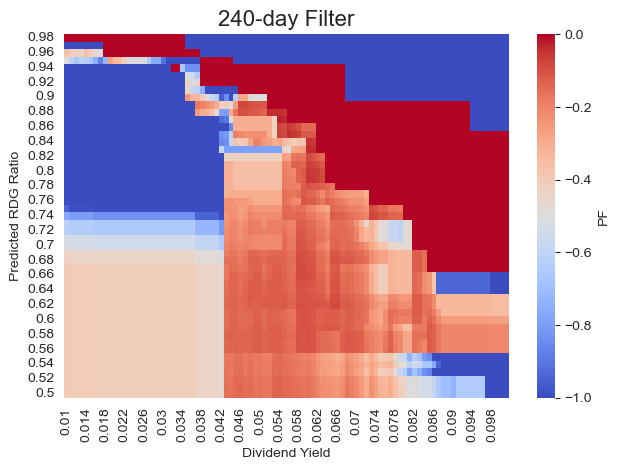

In [15]:
# 投票率填息率 勝率heatmap
x = np.around(np.arange(max(validation_df['投票率'])-0.01,0.5, -0.01), decimals=2)
y = np.around(np.arange(0.01,0.1+0.001, 0.001), decimals=3)
df_winrate = pd.DataFrame(index=x, columns=y)

for i in x:
    for j in y:
        select = (validation_df['投票率'] >= i) & (validation_df['dividend_yield'] >= j)
        fixed_amount = 10000
        trade_list = validation_df[select]
        trade_list['shares'] = (fixed_amount / trade_list['前一日收盤價']).astype(int)
        trade_list['cost'] = trade_list['shares'] * trade_list['前一日收盤價']
        trade_list.loc[trade_list['實際值'] == 1, 'profit'] = trade_list.loc[trade_list['實際值'] == 1, 'shares'] * trade_list.loc[trade_list['實際值'] == 1, '息值(元)']
        trade_list.loc[trade_list['實際值'] != 1, 'profit'] = trade_list.loc[trade_list['實際值'] != 1, 'shares'] * (trade_list.loc[trade_list['實際值'] != 1, '240日後收盤價'] - trade_list.loc[trade_list['實際值'] != 1, '前一日收盤價'])

        if len(trade_list)==0:
            df_winrate.loc[i, j] = -2
        else:
            cum_profits = np.cumsum(trade_list['profit'])
            peak = cum_profits.cummax()
            drawdown = (cum_profits - peak) / peak
            max_drawdown = drawdown.min()

            df_winrate.loc[i, j] = max_drawdown
        # if abs(sum(trade_list[trade_list['profit'] < 0]['profit'])) ==0:
        #     df_winrate.loc[i, j] = 0
        # else:
        #     df_winrate.loc[i, j] = sum(trade_list[trade_list['profit'] > 0]['profit']) / abs(sum(trade_list[trade_list['profit'] < 0]['profit']))

df_winrate = df_winrate.fillna(0)
display(df_winrate)

max_idx = np.argwhere(df_winrate.values == df_winrate.values.max())

if max_idx.shape[0] > 1:
    distances = [np.sqrt(((idx[0]-len(x))**2)+(idx[1]**2)) for idx in max_idx]
    min_distance_idx = np.argmin(distances)
    max_y, max_x = max_idx[min_distance_idx]
else:
    max_y, max_x = max_idx[0]

print("投票率、殖利率為:", df_winrate.index[max_y], df_winrate.columns[max_x])
# max_idx = np.argwhere(df_winrate.values == df_winrate.values.max())
# # 如果有多个最大值
# if max_idx.shape[0] > 1:
#     # 先选取x轴最小的位置，再在这些位置中选取y轴最大的位置
#     min_x = min(max_idx[:, 1])
#     max_y = max(max_idx[max_idx[:, 1] == min_x, 0])
#     max_x = min_x
# else:
#     max_y, max_x = max_idx[0]
# print("投票率、殖利率為:", df_winrate.index[max_y], df_winrate.columns[max_x])

sns.heatmap(df_winrate, cmap='coolwarm', vmin=-1, vmax=df_winrate.values[max_y, max_x], cbar_kws={'label': 'PF', "drawedges": False})
plt.title('240-day Filter',size=16)
plt.xlabel("Dividend Yield")
plt.ylabel("Predicted RDG Ratio")
mpl.rcParams['axes.facecolor'] = 'white'
plt.grid(False)
plt.tight_layout()
plt.savefig(r'C:\股票\figure\240日分類MDD濾網.svg')
plt.show()

,代號,除息日,息值(元),240日不設限填息率,240日填息率,dividend_yield,前一日收盤價,240日後收盤價,預測值,實際值,投票率,延展投票率,cost,profit,shares
0,3265,2016-06-27,0.25,1.0,1.0,0.011364,17.27,19.50,1,1,0.971514,0.943028,9999,144.75,579
1,2823,2016-07-21,0.60,1.0,1.0,0.022140,17.95,22.65,1,1,0.968516,0.937031,9998,334.20,557
2,3583,2016-07-21,1.00,1.0,1.0,0.014347,58.21,53.89,1,1,0.980180,0.960360,9953,171.00,171
3,8390,2016-08-03,0.20,1.0,1.0,0.013029,13.16,13.85,1,1,0.961536,0.923072,9988,151.80,759
4,2702,2016-08-24,0.12,1.0,1.0,0.006877,14.54,13.61,1,1,0.969157,0.938314,9988,82.44,687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,2355,2022-07-26,0.50,1.0,1.0,0.017331,28.35,30.15,1,1,0.976799,0.953598,9979,176.00,352
74,3236,2022-08-26,0.60,1.0,1.0,0.025105,23.30,25.00,1,1,0.960717,0.921435,9995,257.40,429
75,8076,2022-08-30,0.30,1.0,1.0,0.009023,28.52,29.45,1,1,0.963015,0.926031,9982,105.00,350
76,8423,2022-09-13,0.30,1.0,1.0,0.015666,18.30,18.40,1,1,0.962954,0.925908,9991,163.80,546


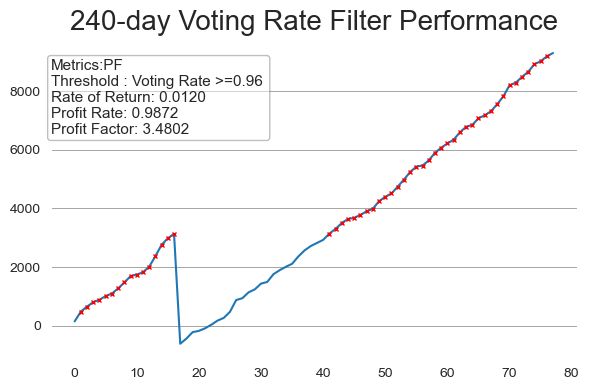

In [80]:
### Improved Juicing回測
voting, dividend = 0.96, 0
fixed_amount = 10000
# re_price = pd.read_csv(r'C:\股票\股票資料\data\還原股價.csv', encoding='cp950', low_memory=False, index_col=False)
backtest_df['cost'] = 0
backtest_df['profit'] = 0
backtest_df['shares'] = 0
trade_list = backtest_df[(backtest_df['投票率'] >= voting) & (backtest_df['dividend_yield']>dividend)].reset_index(drop=True)
# trade_list = backtest_df.sort_values(by=['投票率', 'dividend_yield'], ascending=[False, False]).head(30).reset_index(drop=True)
# ### APPLE JUICE
for i in  range(0, len(trade_list)):
    # df_reprice = re_price[re_price['symbol_id'] == trade_list.loc[i, '代號']].reset_index(drop=True)
    # price_index = df_reprice[(df_reprice['symbol_id'] == trade_list.loc[i, '代號']) & (df_reprice['date'].astype('datetime64') == (trade_list['除息日'][i]))].index[0]
    trade_list['shares'][i] = int(fixed_amount / trade_list['前一日收盤價'][i])
    trade_list['cost'][i] = int(trade_list['shares'][i] * trade_list['前一日收盤價'][i])
    if trade_list['實際值'][i] == 1:
        trade_list['profit'][i] = trade_list['shares'][i] * trade_list['息值(元)'][i]
    else:
        trade_list['profit'][i] = trade_list['shares'][i] * (trade_list['240日後收盤價'][i] - trade_list['前一日收盤價'][i])
#     # for k in range(price_index, len(df_reprice)):
#     #     if df_reprice['c'][k] >= (df_reprice['c'][price_index-1] + trade_list['息值(元)'][i]):
#     #         trade_list['profit'][i] = trade_list['shares'][i] * trade_list['息值(元)'][i]
#     #         break
#     #     elif df_reprice['c'][k] < (df_reprice['c'][price_index-1] - trade_list['息值(元)'][i]):
#     #         trade_list['profit'][i] = -(trade_list['shares'][i] * trade_list['息值(元)'][i])
#     #         break
#     #     else:
#     #         trade_list['profit'][i] = trade_list['shares'][i] * (trade_list['240日後收盤價'][i] - trade_list['前一日收盤價'][i])
# ### 無腦買
# # for l in  range(0, len(backtest_df)):
# #     df_reprice = re_price[re_price['symbol_id'] == backtest_df.loc[l, '代號']].reset_index(drop=True)
# #     price_index = df_reprice[(df_reprice['symbol_id'] == backtest_df.loc[l, '代號']) & (df_reprice['date'].astype('datetime64') == (backtest_df['除息日'][l]))].index[0]
# #     backtest_df['shares'][l] = int(fixed_amount / backtest_df['前一日收盤價'][l])
# #     backtest_df['cost'][l] = int(backtest_df['shares'][l] * backtest_df['前一日收盤價'][l])
# #     if backtest_df['實際值'][l] == 1:
# #         backtest_df['profit'][l] = backtest_df['shares'][l] * backtest_df['息值(元)'][l]
# #     else:
# #         backtest_df['profit'][l] = backtest_df['shares'][l] * (backtest_df['240日後收盤價'][l] - backtest_df['前一日收盤價'][l])
#     # for k in range(price_index, len(df_reprice)):
#     #     if df_reprice['c'][k] >= (df_reprice['c'][price_index-1] + backtest_df['息值(元)'][l]):
#     #         backtest_df['profit'][l] = backtest_df['shares'][l] * backtest_df['息值(元)'][l]
#     #         break
#     #     elif df_reprice['c'][k] < (df_reprice['c'][price_index-1] - backtest_df['息值(元)'][l]):
#     #         backtest_df['profit'][l] = backtest_df['shares'][l] * -(backtest_df['息值(元)'][l])
#     #         break
#     #     else:
#     #         backtest_df['profit'][l] = backtest_df['shares'][l] * (backtest_df['240日後收盤價'][l] - backtest_df['前一日收盤價'][l])
#
display(trade_list)
profit_rate = np.round(sum(trade_list['profit'].tolist()) / sum(trade_list['cost'].tolist()), decimals=4)
win_rate = np.round(len(trade_list[trade_list['profit'] > 0]) / len(trade_list), decimals=4)
if abs(sum(trade_list[trade_list['profit'] < 0]['profit'])) ==0:
    PF = float('inf')
else:
    PF =np.round(sum(trade_list[trade_list['profit'] > 0]['profit']) / abs(sum(trade_list[trade_list['profit'] < 0]['profit'])), decimals=4)

# print('APPLE JUICE [殖利率>',dividend,' & 投票率>',voting,']', len(trade_list))
# print('策略獲利率:', profit_rate)
# # print('策略總獲利為:', sum(trade_list['profit'].tolist()))
# # print('策略總成本為:', sum(trade_list['cost'].tolist()))
# print('策略勝率:', win_rate)
# print('獲利因子為:', PF)
# print('--------------------------------')
# # print('無腦', len(backtest_df))
# # print('無腦獲利率:', sum(backtest_df['profit'].tolist()) / sum(backtest_df['cost'].tolist()))
# # print('無腦總獲利為:', sum(backtest_df['profit'].tolist()))
# # print('無腦總成本為:', sum(backtest_df['cost'].tolist()))
# # print('策略勝率:', len(backtest_df[backtest_df['profit'] > 0]) / len(backtest_df))
# # print('獲利因子為:', sum(backtest_df[backtest_df['profit'] > 0]['profit']) / abs(sum(backtest_df[backtest_df['profit'] < 0]['profit'])))
#
#
pl = np.cumsum(trade_list['profit'].tolist())
# 找出每次最大值的索引
max_indices = []
for i in range(1, len(pl)-1):
    if pl[i] > max(pl[:i]):
        max_indices.append(i)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(pl)

# 在每次最大值的位置上繪製記號
for i in max_indices:
    ax.plot(i, pl[i], marker='x', color='red', markersize=3)
mpl.rcParams['axes.facecolor'] = 'white'
ax.grid(color='gray', linewidth=0.5, axis='y')
ax.text(0, 0.7, f'Metrics:PF\nThreshold : Voting Rate >={voting:.2f} \nRate of Return: {profit_rate:.4f} \nProfit Rate: {win_rate:.4f}\nProfit Factor: {PF:.4f}', transform=ax.transAxes, fontsize=11, bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray', boxstyle='round,pad=0.2'))
ax.set_title('240-day Voting Rate Filter Performance',size=20)
plt.tight_layout()
plt.savefig(r'C:\股票\figure\濾網、交易績效\一維濾網\240日分類PF濾網回測.svg')
plt.show()